In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= self.get_random_from_samples()
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            
            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    def get_random_from_samples(self):
            if self._samples==[]:
                return torch.rand(self._n).to(device)
            return self._samples[self._t-1]

In [2]:
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

In [8]:
TestCases= [500, 1000, 1500]
TestNumPer= 20
TestResults= {}
sim_deter_result=[]

for n in TestCases:
    TestResults[n]= []

for n in TestCases:
    #random to be used
    dIsamples=[]
    avgDegree = 10  #every individual will have 10 contacts on average
    pinf = 0.2  #it is the first parameter we are going to fit
    time_horizon = 20
    #create  dense contacts
    contacts = generate_random_network(n, avgDegree)
    contacts = contacts.coalesce()#make pairs unique
    contacts = contacts.to_dense()
    contacts = contacts.requires_grad_(True)
    for _ in range(time_horizon):
        dIsamples.append(torch.rand(n).to(device))
    #si true 
    si = SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
        samples=dIsamples, device=device)
            #generate real data
    si_result= None
    with torch.no_grad():
        population = Population(n, device=device)
        si_result, _ = sim(time_horizon, population, si, mode="run")
    #dIs_result= dIs_result.sum(dim=1)
    stats_gt   = si_result.sum(dim=3) # si along 20 iterations
    stats_gt   = stats_gt.squeeze()
    stats_gt.requires_grad_(True)
    si_fit_deter = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  
                            infectiveness_name="infectiveness", samples=dIsamples, device=device)
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(si_fit_deter.parameters(), lr=1e-2)
    for i in range(250):
        optimizer.zero_grad()
        si_fit_deter._t=0
        population = Population(n, device=device)
        si_pred, IMeans_pred = sim(time_horizon, population, si_fit_deter, mode="train")
        loss = loss_fn(stats_gt, IMeans_pred)
        loss.backward(retain_graph=True)
        optimizer.step()
    sim_deter_result.append(si_fit_deter._pinf.item())
    
    
    for j in range(TestNumPer):
        print(n, " ", j)
        #si fit
        si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                        samples=[], device=device)
        #deinfe loss function
        loss_fn = torch.nn.MSELoss(reduction='sum')
        optimizer = torch.optim.Adagrad(si_fit.parameters(), lr=5e-2, weight_decay=1e-2, lr_decay=1e-2)
        colors = [("red", 'I')]
        age_sizes = [n]
        fitPinfs=[]
        for i in range(250):
            if i>248:
                fitPinfs.append(si_fit._pinf.item())
            optimizer.zero_grad()
            si_fit._t=0
            population = Population(n, device=device)
            si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
            loss = loss_fn(stats_gt, IMeans_pred)
            loss.backward(retain_graph=True)
            optimizer.step()
        print(si_fit._pinf.item())
        TestResults[n].append(sum(fitPinfs)/len(fitPinfs))
        torch.cuda.empty_cache()


500   0
0.2053707242012024
500   1
0.19678537547588348
500   2
0.2082112729549408
500   3
0.20449985563755035
500   4
0.20319510996341705
500   5
0.2052801549434662
500   6
0.2025114744901657
500   7
0.20204204320907593
500   8
0.20623314380645752
500   9
0.20275726914405823
500   10
0.2025720328092575
500   11
0.20482845604419708
500   12
0.20896565914154053
500   13
0.2027132213115692
500   14
0.20601429045200348
500   15
0.20545263588428497
500   16
0.2108551561832428
500   17
0.2007618397474289
500   18
0.20539399981498718
500   19
0.2072208970785141
1000   0
0.1494600623846054
1000   1
0.15006835758686066
1000   2
0.1549854427576065
1000   3
0.15182894468307495
1000   4
0.15830108523368835
1000   5
0.1532147228717804
1000   6
0.15548405051231384
1000   7
0.15831971168518066
1000   8
0.15290097892284393
1000   9
0.14636649191379547
1000   10
0.14931535720825195
1000   11
0.15251098573207855
1000   12
0.15283051133155823
1000   13
0.1549244225025177
1000   14
0.15449948608875275
100

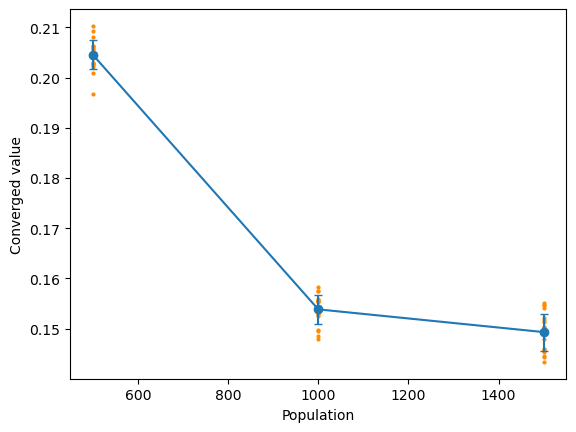

[0.20453468710184097, 0.15383214876055717, 0.149307169765234]
[0.0029331461408070446, 0.0028966337493239263, 0.0036843627086036216]


In [9]:
import numpy as np
x=[]
y=[]
xs=[]
means= []
stds= []
for n in TestCases:
    vector= np.array(TestResults[n])
    xs.append(n)
    means.append(np.mean(vector))
    stds.append(np.sqrt(np.var(vector)))
    for m in TestResults[n]:
        x.append(n)
        y.append(m)
plt.scatter(x, y, c="darkorange", s= 4)
plt.errorbar(xs, means, stds, marker='o', capsize=3)
plt.xlabel("Population")
plt.ylabel("Converged value")
plt.show()
print(means)
print(stds)


In [9]:
print(sim_deter_result)

[0.2294812798500061, 0.15947535634040833, 0.21727563440799713]
